## Why RNNs/CNNs?

1. Is TF-IDF aware to the word order?
2. Can TF-IDF vecter capture the contextual information?
    1. “I will fly a plane someday”
    2. “That tiny buzzing fly landed on my fresh food while I was eating”
3. How can we better represent words in sentences and extract the representation of a sentence?

<img src="img/workflow.jpg", width=320, heigth=240>
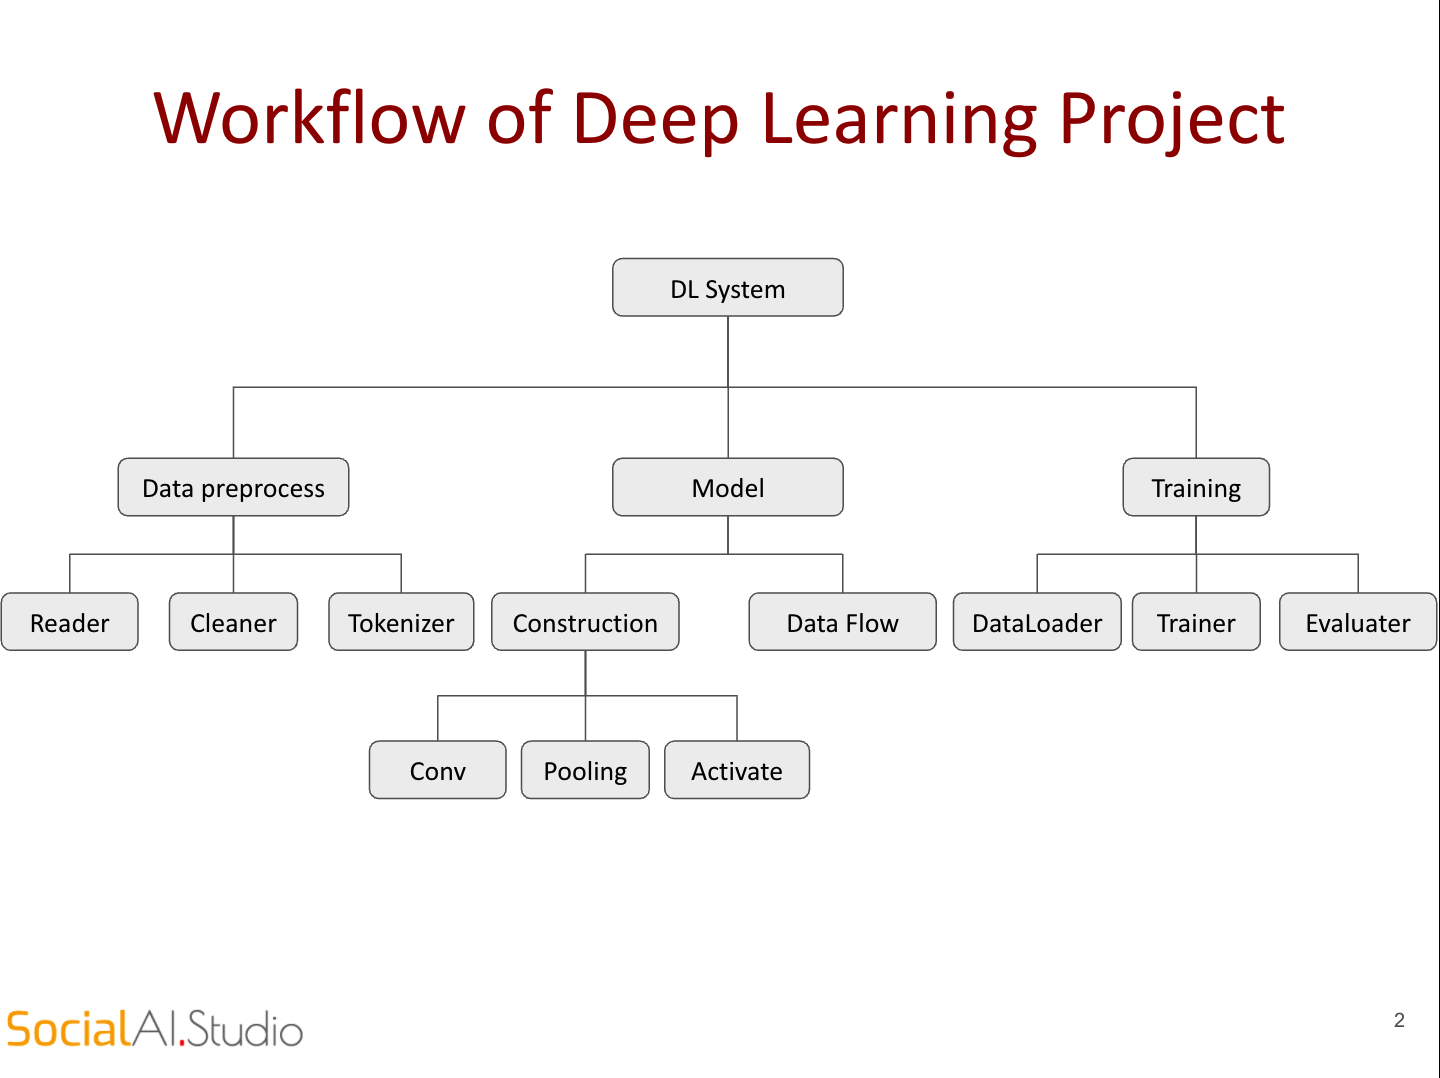

<img src="img/dataflow.jpg", width=320, heigth=240>
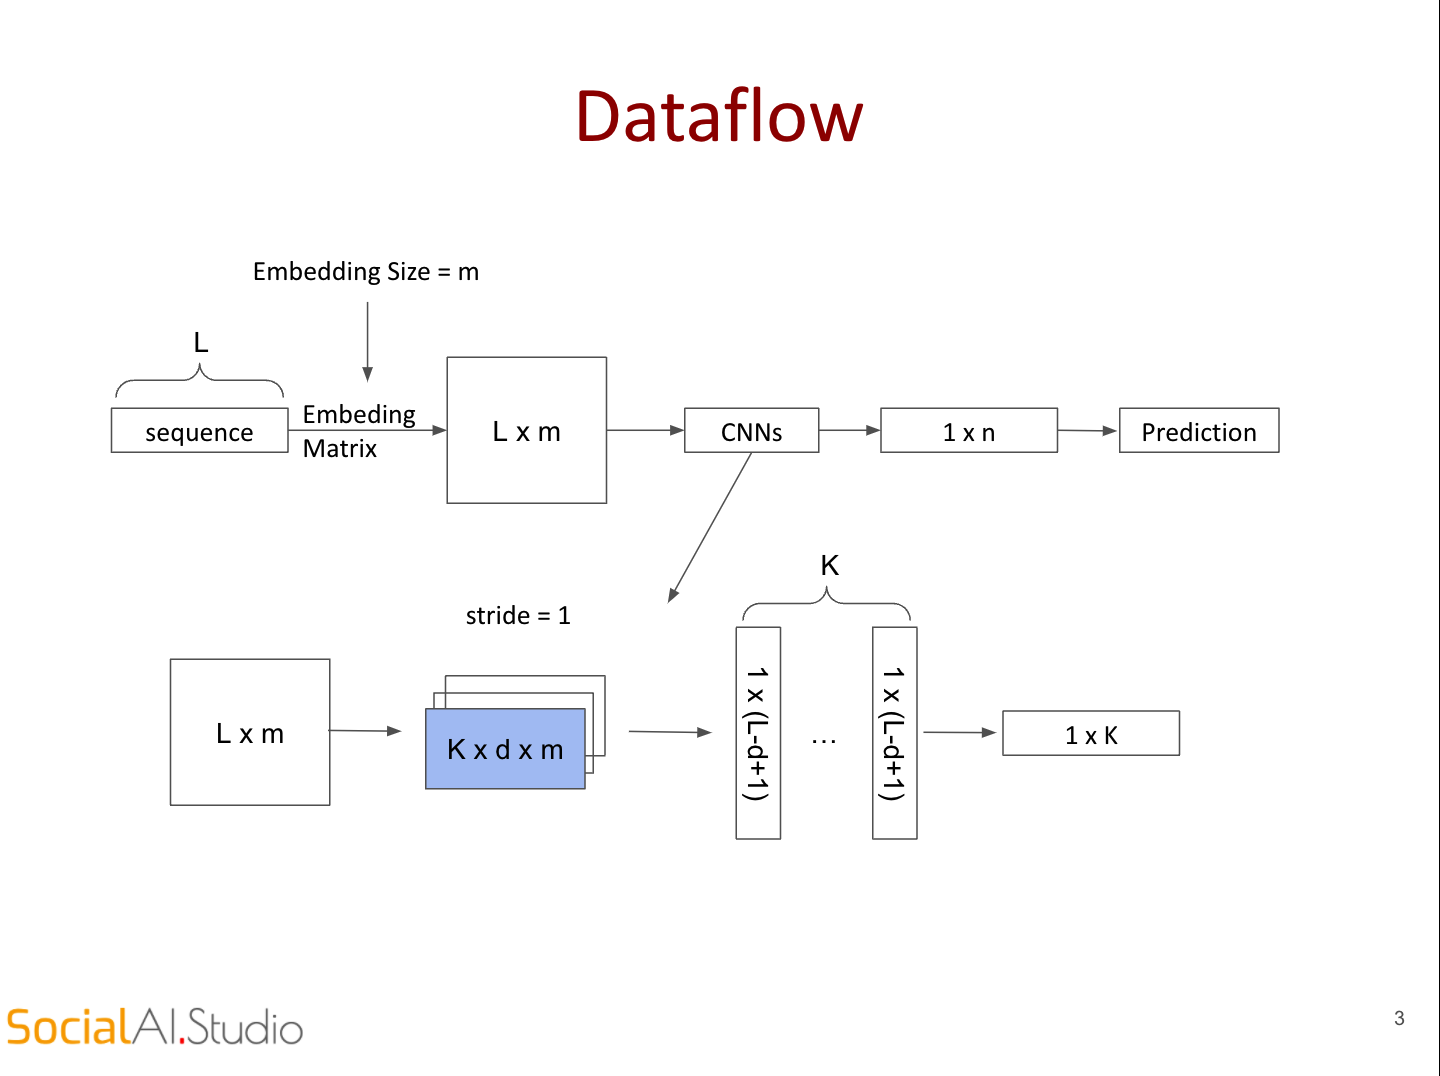

## Data loading and preprocessing
### Data format
<img src="img/dataset.jpg", width=320, heigth=240>
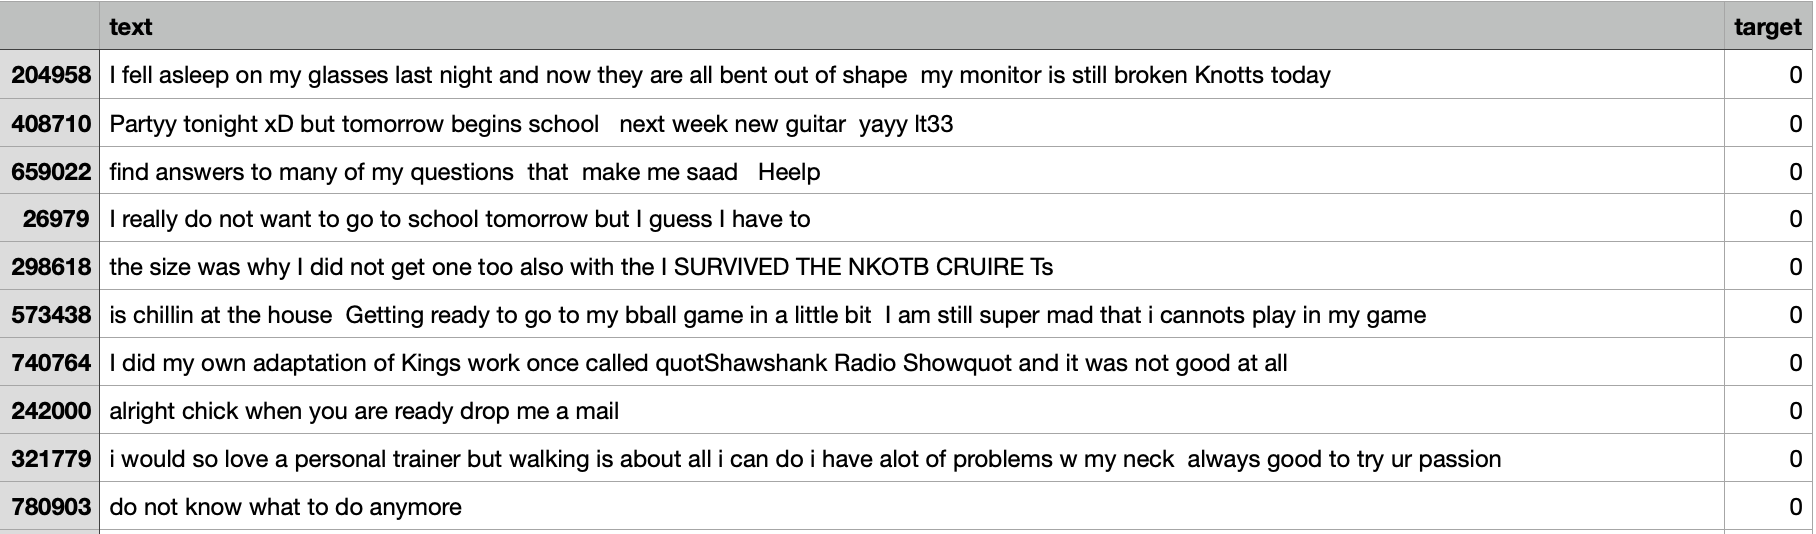

### import libraries 

In [61]:
import re
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [62]:
class args:

   # Preprocessing parameeters
    seq_len: int = 50
    num_words: int = 3000
   
   # Model parameters
    embedding_size: int = 128
    out_size: int = 64
    stride: int = 2
   
   # Training parameters
    epochs: int = 20
    batch_size: int = 32
    learning_rate: float = 0.001
    use_gpu: bool = True

### Function to load text

In [63]:
def load_text(data_path):
    """Load text data, lowercase text and save to a list."""
    df = pd.read_csv(data_path)
    texts = [df['text'][i] for i in range(len(df['text']))]
    labels = df['target'][:]
    labels = [0 if label == 0 else 1 for label in labels]
    return texts, labels

### Read data

In [69]:
data_path = 'data/cleaned_workshop_data_10K.csv'
texts, labels = load_text(data_path)

for i in range(10):
    print('text {}: {}'.format(i, texts[i]))
print(labels[-10:])

text 0: I fell asleep on my glasses last night and now they are all bent out of shape  my monitor is still broken Knotts today
text 1: Partyy tonight xD but tomorrow begins school   next week new guitar  yayy lt33
text 2: find answers to many of my questions  that  make me saad   Heelp 
text 3: I really do not want to go to school tomorrow but I guess I have to 
text 4: the size was why I did not get one too also with the I SURVIVED THE NKOTB CRUIRE Ts 
text 5: is chillin at the house  Getting ready to go to my bball game in a little bit  I am still super mad that i cannots play in my game  
text 6: I did my own adaptation of Kings work once called quotShawshank Radio Showquot and it was not good at all 
text 7: alright chick when you are ready drop me a mail 
text 8: i would so love a personal trainer but walking is about all i can do i have alot of problems w my neck  always good to try ur passion
text 9: do not know what to do anymore 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


### Data preprocessing

1. clean text
2. Word tokenization
3. Padding
4. Split into train and test

### Clean text
if the text data catains too much noise, we need to clean the data first.
For example, some tweets have '@user', hashtags, URLs, and so on. We will usually remove these special symbols.

In [70]:
def clean_text(texts):
  # Removes special symbols
  pass

### Word tokenization
For tokenization, we are going to make use of the word_tokenize function from the nltk library (a very simple way to tokenize a sentence).

In [71]:
def text_tokenization(texts):
  # Tokenizes each sentence by implementing the nltk tool
    texts = [word_tokenize(x) for x in texts]
    return texts
    
texts = text_tokenization(texts)
print(texts[0])

['I', 'fell', 'asleep', 'on', 'my', 'glasses', 'last', 'night', 'and', 'now', 'they', 'are', 'all', 'bent', 'out', 'of', 'shape', 'my', 'monitor', 'is', 'still', 'broken', 'Knotts', 'today']


After this, we will need to generate a dictionary with the “n” most frequent words in the dataset.

In [72]:
def build_vocabulary(texts, num_words):
  # Builds the vocabulary and keeps the "x" most frequent words
    vocab = dict()
  
    fdist = nltk.FreqDist()   
    for sentence in texts:
        for word in sentence:
            fdist[word] += 1
  
    common_words = fdist.most_common(num_words)
  
    for idx, word in enumerate(common_words):
        vocab[word[0]] = (idx+1)
    return vocab

vocab = build_vocabulary(texts, args.num_words)

In [74]:
print(vocab)

{'I': 1, 'to': 2, 'the': 3, 'is': 4, 'a': 5, 'not': 6, 'you': 7, 'my': 8, 'it': 9, 'and': 10, 'i': 11, 'am': 12, 'for': 13, 'in': 14, 'have': 15, 'of': 16, 'me': 17, 'on': 18, 'that': 19, 'so': 20, 'do': 21, 'are': 22, 'but': 23, 'can': 24, 'at': 25, 'with': 26, 'will': 27, 'be': 28, 'was': 29, 'just': 30, 'up': 31, 'going': 32, 'this': 33, 'all': 34, 'now': 35, 'like': 36, 'day': 37, 'out': 38, 'get': 39, 'good': 40, 'go': 41, 'got': 42, 'too': 43, 'work': 44, 'love': 45, 'your': 46, 'today': 47, 'want': 48, 'what': 49, 'we': 50, 'no': 51, 'from': 52, 'time': 53, 'know': 54, 'back': 55, 'really': 56, 'did': 57, 'about': 58, 'amp': 59, 'one': 60, 'some': 61, 'think': 62, 'had': 63, 'there': 64, 'night': 65, 'home': 66, 'when': 67, 'would': 68, 'see': 69, 'lol': 70, 'they': 71, 'as': 72, 'still': 73, '2': 74, 'well': 75, 'if': 76, 'here': 77, 'miss': 78, 'more': 79, 'off': 80, 'how': 81, 'its': 82, 'he': 83, 'need': 84, 'tomorrow': 85, 'been': 86, 'last': 87, 'new': 88, 'an': 89, 'much'

Until now each tweet is already tokenized, however we need to transform each word token into a numeric format, therefore we will use the dictionary generated in Code 3 to transform each word into its representation based on indexes.

In [75]:
def word_to_idx(texts, vocab):
  # By using the dictionary (vocab), it is transformed
  # each token into its index based representation	
  
    x_ids = list()
  
    for sentence in texts:
        temp_sentence = list()
        for word in sentence:
            if word in vocab.keys():
                temp_sentence.append(vocab[word])
        x_ids.append(temp_sentence)
    return x_ids

text_ids = word_to_idx(texts, vocab)
print(texts[0])
print(text_ids[0])

['I', 'fell', 'asleep', 'on', 'my', 'glasses', 'last', 'night', 'and', 'now', 'they', 'are', 'all', 'bent', 'out', 'of', 'shape', 'my', 'monitor', 'is', 'still', 'broken', 'Knotts', 'today']
[1, 1270, 643, 18, 8, 1163, 87, 65, 10, 35, 71, 22, 34, 38, 16, 8, 2331, 4, 73, 792, 47]


### Padding
Why does we need padding?

Because we will do batch training, and we expect the length of the sentences is equal in the same batch. 

What value will be padded?

Usually 0.


In [76]:
def padding_sentences(text_ids, args):
  # Each sentence which does not fulfill the required len
  # it's padded with the index 0
  
    pad_idx = 0
    text_padded = list()
  
    for text in text_ids:
        if len(text) < args.seq_len:
            text += [0 for i in range(args.seq_len-len(text))]
        else:
            text = text[:args.seq_len]
        text_padded.append(text)
    
    text_padded = np.array(text_padded)
    return text_padded

text_padded = padding_sentences(text_ids, args)
print(text_padded[0])

[   1 1270  643   18    8 1163   87   65   10   35   71   22   34   38
   16    8 2331    4   73  792   47    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


### Split intro train and test
The last step in this preprocessing pipeline is to divide the data into training and testing. For this we will use the function provided by scikit learn.

In [79]:
def split_data(text_padded):
    x_train, x_test, y_train, y_test = train_test_split(text_padded, labels, test_size=0.2, random_state=132022)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data(text_padded)

data = {'x_train': x_train, 'x_test': x_test, 'y_train': y_train, 'y_test': y_test}

print('Length of training data:{}'.format(len(x_train)))
print('Length of test data:{}'.format(len(x_test)))

Length of training data:8000
Length of test data:2000


### Show me the code
CNN model class

### Import libraries

In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [112]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim, 
        kernel_sizes, 
        num_filters, 
        num_classes, d_prob):
        super(TextCNN, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.num_classes = num_classes
        self.d_prob = d_prob
        self.embedding = nn.Embedding(
            vocab_size+1, embedding_dim, padding_idx=0)
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim,
                                             out_channels=num_filters,
                                             kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(d_prob)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, num_classes)

    def forward(self, x):
        batch_size, sequence_length = x.shape
        x = self.embedding(x).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(self.dropout(x))
        return torch.softmax(x, dim=1).squeeze()
    

In [113]:
model = TextCNN(vocab_size=args.num_words,
                embedding_dim=args.embedding_size,
                kernel_sizes=[2, 3, 4, 5],
                num_filters=100,
                num_classes=2, 
                d_prob=0.5)

## Training
### Dataloader
As we saw in the preprocessing phase, the training and test data are ready to be implemented. However, we need to transform them to a torch-based data type as well as create the batch generator. For this we will make use of the Dataset and DataLoader modules that the PyTorch framework provides, this is how the implementation will look like:

In [114]:
from torch.utils.data import Dataset, DataLoader

class DatasetMaper(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y
      
    def __len__(self):
        return len(self.x)
      
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

To make use of the class, we only need to instantiate and then initialize the dataloader.

In [115]:
# Initialize dataset maper
train = DatasetMaper(data['x_train'], data['y_train'])
test = DatasetMaper(data['x_test'], data['y_test'])

# Initialize loaders
loader_train = DataLoader(train, batch_size=args.batch_size)
loader_test = DataLoader(test, batch_size=args.batch_size)

For the training phase, we have to define the dataloader (we did this in the previous step) and define the optimizer (in this case we are using the Adam optimizer). Once everything is ready, we can start with the training loop.

In [116]:
def train(model, data, args):
    if args.use_gpu:
        model.to('cuda')
   
    # Initialize dataset maper
    train = DatasetMaper(data['x_train'], data['y_train'])
    test = DatasetMaper(data['x_test'], data['y_test'])
   
    # Initialize loaders
    loader_train = DataLoader(train, batch_size=args.batch_size)
    loader_test = DataLoader(test, batch_size=args.batch_size)
   
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    
    #Define Loss
    loss_func = nn.CrossEntropyLoss()
   
    # Starts training phase
    for epoch in range(args.epochs):
        # Set model in training model
        model.train()
        predictions = []
        # Starts batch training
        for x_batch, y_batch in loader_train:
            
            # Clean gradientes
            optimizer.zero_grad()
      
            y_batch = torch.LongTensor(y_batch)
            
            if args.use_gpu:
                x_batch = x_batch.to('cuda')
                y_batch = y_batch.to('cuda')
         
            # Feed the model
            y_pred = model(x_batch)
            
            # Loss calculation
            loss = loss_func(y_pred, y_batch)

            # Gradients calculation
            loss.backward()

            # Gradients update
            optimizer.step()

            # Save predictions
            predictions += y_pred.tolist()
      
        # Evaluation phase
        test_predictions = evaluation(model, loader_test, args)
      
        # Metrics calculation
        train_accuary = calculate_accuray(data['y_train'], predictions)
        test_accuracy = calculate_accuray(data['y_test'], test_predictions)
        print("Epoch: %d, loss: %.5f, Train accuracy: %.5f, Test accuracy: %.5f" % (epoch+1, loss.item(), train_accuary, test_accuracy))


In [117]:
def evaluation(model, loader_test, args):
    # Set the model in evaluation mode
    model.eval()
    predictions = []

    # Starst evaluation phase
    with torch.no_grad():
        for x_batch, y_batch in loader_test:
            x_batch = torch.LongTensor(x_batch)
            if args.use_gpu:
                x_batch = x_batch.to('cuda')
                y_batch = y_batch.to('cuda')
            y_pred = model(x_batch)
            predictions += y_pred.tolist()
    return predictions

In [118]:
def calculate_accuray(grand_truth, predictions):
    true_positives = 0
    true_negatives = 0
   
    # Gets frequency  of true positives and true negatives
    # The threshold is 0.5
    for true, pred in zip(grand_truth, predictions):
        if (pred[1] >= 0.5) and (true == 1):
            true_positives += 1
        elif (pred[1] < 0.5) and (true == 0):
            true_negatives += 1
        else:
            pass
    # Return accuracy
    return (true_positives+true_negatives) / len(grand_truth)

In [119]:
train(model, data, args)

Epoch: 1, loss: 0.69256, Train accuracy: 0.61187, Test accuracy: 0.66200
Epoch: 2, loss: 0.64612, Train accuracy: 0.71825, Test accuracy: 0.69150
Epoch: 3, loss: 0.59515, Train accuracy: 0.77187, Test accuracy: 0.70200
Epoch: 4, loss: 0.55492, Train accuracy: 0.80175, Test accuracy: 0.69650
Epoch: 5, loss: 0.51151, Train accuracy: 0.83188, Test accuracy: 0.71250
Epoch: 6, loss: 0.48267, Train accuracy: 0.84337, Test accuracy: 0.71850
Epoch: 7, loss: 0.37587, Train accuracy: 0.86300, Test accuracy: 0.72700
Epoch: 8, loss: 0.39803, Train accuracy: 0.88000, Test accuracy: 0.72800
Epoch: 9, loss: 0.35595, Train accuracy: 0.89125, Test accuracy: 0.72300
Epoch: 10, loss: 0.41376, Train accuracy: 0.89438, Test accuracy: 0.73050
Epoch: 11, loss: 0.38173, Train accuracy: 0.89325, Test accuracy: 0.72550
Epoch: 12, loss: 0.41048, Train accuracy: 0.90975, Test accuracy: 0.72300
Epoch: 13, loss: 0.39019, Train accuracy: 0.90987, Test accuracy: 0.72700
Epoch: 14, loss: 0.43672, Train accuracy: 0.915